In [221]:
import os
import sys
import re

import numpy as np
import pandas as pd
import seaborn as sns
import math
import random

import tools as tl
from coralModel import Reef, Organism, Ocean

import matplotlib.pyplot as plt
import matplotlib.colors as clt
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

In [67]:
## Function to pull info from image
def reef_from_image(image, threshold, number_of_rows, number_of_columns):
    
    Moorea = Reef()
    count=0
    for i in range(0, number_of_rows):
        for j in range(0, number_of_columns):
            
            node = Organism(type=image[i,j], 
                            location=[i,j], 
                            ID=count)
            Moorea.append(node)
            count = count + 1
    Moorea.generate_graph(1.45)
    #densities = np.array([Moorea.nodes[n].neighbors[0] for n,val in enumerate(Moorea.nodes)])
    #values = [Moorea.nodes[n].type for n,val in enumerate(Moorea.nodes)]
    return(Moorea)

def extract_neighbors(Moorea, node, count):
    if count == 0:
        neighbors = 0
    else:
        neighbors = np.array([Moorea.nodes[n].neighbors/
                              Moorea.nodes[n].neighbors.sum()
                              for n,val in enumerate(Moorea.nodes)
                              if Moorea.nodes[n].type == node]).mean(axis=0)
    return(neighbors)

def prep_image(df, simulation, time):    
    image = df[(df['time']==time)&(df['simulation']==simulation)]['image']
    image = np.genfromtxt([image.values[0].replace('[', '').replace(']', '')])
    image = np.reshape(image, (25,25))
    return(image)
    
## For plots
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p] 

def create_reef(simulation): 
    
    Moorea = Reef()
    count = 0
    for i in range(0, number_of_rows): 
        for j in range(0, number_of_columns):
            if grid_option == 3: ##for threshold plotting
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            Moorea.append(node)
            count = count + 1
    return(Moorea)

In [3]:
path = './figures/paper/3_threshold_change/'
extension = '.png'

top_directory = "./output/" #os.getcwd()
files, runs = tl.view_runs(top_directory)

## A. Threshold Setup Visual

In [4]:
## Create Images

thresholds = [1.45, 36]
number_of_rows, number_of_columns = 25,25
number_of_nodes = number_of_rows * number_of_columns
middle_node =  68 #27 #round(rows*rows/2)
simulation = 19

threshold_images = []
grid_option = 3 #specifically for plotting thresholds
reef = create_reef(simulation)

for threshold in thresholds:
    
    reef.generate_graph(threshold)
    neighbors = reef.graph[middle_node]
    
    for neighbor in neighbors:
        reef.nodes[neighbor].type = 1 
        
    reef.nodes[middle_node].type = 2
    
    reef_types = np.array([reef.nodes[i].type for i,val in enumerate(reef.nodes)], dtype=float)   
    threshold_images.append(np.reshape(reef_types, (number_of_rows, number_of_columns)))

In [5]:
## Plot Parameters

titles = ['$\ell$ = '+str(thresholds[0]), 
          '$\ell$ = '+str(thresholds[1])]
levels = [0, 1, 2]
colors = ['#f0f0f0', 'yellow', '#522B29']
legend_lables = ['Invisible', 'Neighborhood', 'Node of interest']
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')

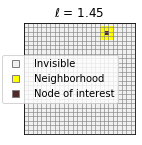

In [6]:
## Plot

fig, ax = plt.subplots(1,1, figsize=(2,2.5))  

name = 'topology_visual_1'
ax.imshow(threshold_images[0], cmap=cmap, norm=norm)#, interpolation='none', aspect='equal') 
ax.set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax.set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax.set_frame_on(False)
ax.set_yticks([])
ax.set_xticks([])
ax.grid(color='grey', linestyle='-', linewidth=.6, which='minor')
ax.set_title(titles[0])
ax.tick_params(which='minor', top=[], left=[], right=[], bottom=[])
ax.set_frame_on(True)
patches = [mpatches.Patch(facecolor=colors[i], edgecolor="grey", label=legend_lables[i]) for i in levels]
fig.legend(handles=patches, bbox_to_anchor=(.82, .50), borderaxespad=0., handler_map={patches[i]:HandlerSquare() for i in levels})
fig.subplots_adjust(top=.94)
plt.savefig(path + name + extension, dpi=200)
plt.show()

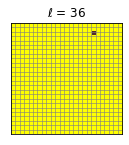

In [7]:
fig, ax = plt.subplots(1,1, figsize=(2,2.5))  

name = 'topology_visual_2'
ax.imshow(threshold_images[1], cmap=cmap, norm=norm)#, interpolation='none', aspect='equal') 
ax.set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax.set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax.set_frame_on(False)
ax.set_yticks([])
ax.set_xticks([])
ax.grid(color='grey', linestyle='-', linewidth=.6, which='minor')
ax.set_title(titles[1])
ax.tick_params(which='minor', top=[], left=[], right=[], bottom=[])
ax.set_frame_on(True)
patches = [mpatches.Patch(facecolor=colors[i], edgecolor="grey", label=legend_lables[i]) for i in levels]
#fig.legend(handles=patches, bbox_to_anchor=(.80, .40), borderaxespad=0., handler_map={patches[i]:HandlerSquare() for i in levels})
fig.subplots_adjust(top=.94)
plt.savefig(path + name + extension, dpi=200)
plt.show()

## Plotted Together Option:

In [19]:
## Plot Parameters

# Names
name = 'neighborhood_definition' 
titles = [r"Threshold ($\ell$) = "+str(thresholds[0]), 
          r"Threshold ($\ell$) = "+str(thresholds[1])]
legend_lables = ['Invisible', 'Neighborhood', 'Node of interest']

# Color Scheme
levels = [0, 1, 2]
colors = ['#f0f0f0', 'yellow', '#522B29']
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')



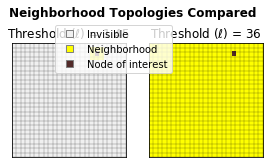

In [20]:
def neighborhood_visualization():
    
    fig, ax = plt.subplots(1,2, figsize=(4.5,3))  
    fig.suptitle('Neighborhood Topologies Compared', fontweight='bold')
    
    for index, value in enumerate(threshold_images):
        ax[index].imshow(value, cmap=cmap, norm=norm)
        ax[index].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
        ax[index].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
        ax[index].set_frame_on(False)
        ax[index].set_yticks([])
        ax[index].set_xticks([])
        ax[index].grid(color='black', linestyle='-', linewidth=.2, which='minor')
        ax[index].set_title(titles[index])
        ax[index].tick_params(which='minor',top=[], left=[],right=[], bottom=[])
        ax[index].set_frame_on(True)
    patches = [mpatches.Patch(facecolor=colors[i], edgecolor="grey", label=legend_lables[i]) for i in levels]
    fig.legend(handles=patches,
               borderaxespad=0., handler_map={patches[i]:HandlerSquare() for i in levels},
               loc='center', bbox_to_anchor=(0.35,.55), shadow=False, ncol=1)
    fig.subplots_adjust(top=.97)
    plt.savefig(path + name + extension, dpi=200)
    plt.show()

neighborhood_visualization()

## B. Initial Image

In [22]:
## Data Overview

subset = runs[(runs['number_of_rows']==25)&
              (runs['grazing'].isin([51,52,53,54,55]))&
              (runs['grid_option']==0)&
              (runs['initial_coral_percent']==33)&
              (runs['neighborhood_threshold'].isin([145,3600]))]
subset.head()

,number_of_rows,number_of_columns,grid_option,grazing,neighborhood_threshold,initial_coral_percent,initial_macroalgae_percent,r,d,a,y,number_of_timesteps,record_rate,number_of_simulations,file
0,25,25,0,51,145,33,33,10,40,20,75,2100,10,100,0
1,25,25,0,51,3600,33,33,10,40,20,75,2100,10,100,1
6,25,25,0,52,145,33,33,10,40,20,75,2100,10,100,6
7,25,25,0,52,3600,33,33,10,40,20,75,2100,10,100,7
8,25,25,0,55,145,33,33,10,40,20,75,2100,10,100,8


In [111]:
# Load Data

df = tl.load_runs(files, subset)
df = tl.split_neighbors(df)
df = tl.add_percent(df)
df = tl.label_crash_statistics(df, coral_success=70)

df['time'] = df['timestep']*.1
df['time'] = df['time'].astype('int')
df['C'] = round(df.coral_percent/100,2)
df['T'] = round(df.turf_percent/100,2)
df['M'] = round(df.macroalgae_percent/100,2)

In [57]:
## Plot Parameters

# Names
name = 'initial_profile'

# Color Scheme
levels = [0, 1, 2]
colors = ['#EE8382', '#508991', '#172A3A']
type_palette = sns.set_palette(sns.color_palette(colors))
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')

# Parameters
simulation = 1
time = 0
threshold = 1.45

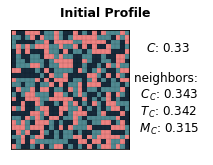

In [60]:
## Plot

data=df[df['neighborhood_threshold']==int(threshold*100)]    
image = prep_image(data, simulation, time)
reef = reef_from_image(image, threshold=threshold, number_of_rows=25, number_of_columns=25)
coral_count = np.count_nonzero(image==0)
neighbors = extract_neighbors(reef, int(0), coral_count)


fig, ax = plt.subplots(1,2, figsize=(3.5,2.45), gridspec_kw={'width_ratios': [2, 1]})

ax[0].imshow(image, cmap=cmap, norm=norm)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax[0].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax[0].set_frame_on(False)
ax[0].grid(color='black', linestyle='-', linewidth=.1, which='minor')
ax[0].tick_params(which='minor',top=[], left=[],right=[], bottom=[])
ax[0].set_frame_on(True)

ax[1].text(0.35, 0.5,
           '$C$: ' + str(round(coral_count/(number_of_rows*number_of_columns), 2)) + 
           '\n \n' + 'neighbors: ' + 
           '\n $C_C$: ' + str(round(neighbors[0],3)) + 
           '\n $T_C$: ' + str(round(neighbors[1],3)) +
           '\n $M_C$: ' + str(round(neighbors[2],3)),
           size=12, ha='center', va='center')
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_frame_on(False)

plt.suptitle("Initial Profile",fontweight='bold',fontsize=12.5)
fig.subplots_adjust(wspace=0.2, top=.9)
plt.savefig(path + name + extension, dpi=400, bbox_inches = "tight")

## C. Time = 10 image

### l = 1.45

In [217]:
## Plot Parameters

# Name
name='t_10_l_145' 

# Color Scheme
levels = [0, 1, 2]
colors = ['#EE8382', '#508991', '#172A3A']
type_palette = sns.set_palette(sns.color_palette(colors))
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')
output_facecolor = '#EDEDED'

# Parameters
time = 10
threshold = 1.45
simulation=1
grazing = 54

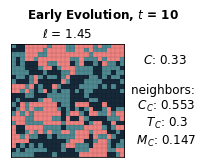

In [218]:
## Plot

data=df[(df['neighborhood_threshold']==int(threshold*100)) & (df['grazing']==grazing)]    
image = prep_image(data, simulation, time)
reef = reef_from_image(image, threshold=threshold, number_of_rows=25, number_of_columns=25)
coral_count = np.count_nonzero(image==0)
neighbors = extract_neighbors(reef, int(0), coral_count)


fig, ax = plt.subplots(1,2, figsize=(3.5,2.45), gridspec_kw={'width_ratios': [2, 1]})

ax[0].imshow(image, cmap=cmap, norm=norm)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax[0].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax[0].set_frame_on(False)
ax[0].grid(color='black', linestyle='-', linewidth=.1, which='minor')
ax[0].tick_params(which='minor',top=[], left=[],right=[], bottom=[])
ax[0].set_frame_on(True)
ax[0].set_title("$\ell$ = " + str(threshold))

ax[1].text(0.35, 0.5,
           '$C$: ' + str(round(coral_count/(number_of_rows*number_of_columns), 2)) + 
           '\n \n' + 'neighbors: ' + 
           '\n $C_C$: ' + str(round(neighbors[0],3)) + 
           '\n $T_C$: ' + str(round(neighbors[1],3)) +
           '\n $M_C$: ' + str(round(neighbors[2],3)),
           size=12, ha='center', va='center')
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_frame_on(False)

plt.suptitle("Early Evolution, $t$ = 10",fontweight='bold',fontsize=12)
fig.subplots_adjust(wspace=0.2, top=.77)
plt.savefig(path + name + extension, dpi=400, bbox_inches = "tight", facecolor=output_facecolor)

### l = 36

In [219]:
## Plot Parameters

# Name
name='t_10_l_36' 


# Color Scheme
levels = [0, 1, 2]
colors = ['#EE8382', '#508991', '#172A3A']
type_palette = sns.set_palette(sns.color_palette(colors))
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')
output_facecolor = '#EDEDED'

# Parameters
time = 10
threshold = 36
simulation=1

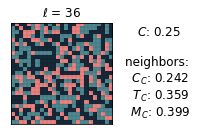

In [220]:
## Plot

data=df[(df['neighborhood_threshold']==int(threshold*100))& (df['grazing']==grazing)]    
image = prep_image(data, simulation, time)
reef = reef_from_image(image, threshold=threshold, number_of_rows=25, number_of_columns=25)
coral_count = np.count_nonzero(image==0)
neighbors = extract_neighbors(reef, int(0), coral_count)


fig, ax = plt.subplots(1,2, figsize=(3.5,2.45), gridspec_kw={'width_ratios': [2, 1]})

ax[0].imshow(image, cmap=cmap, norm=norm)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax[0].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
ax[0].set_frame_on(False)
ax[0].grid(color='black', linestyle='-', linewidth=.1, which='minor')
ax[0].tick_params(which='minor',top=[], left=[],right=[], bottom=[])
ax[0].set_frame_on(True)
ax[0].set_title("$\ell$ = " + str(threshold))

ax[1].text(0.35, 0.5,
           '$C$: ' + str(round(coral_count/(number_of_rows*number_of_columns), 2)) + 
           '\n \n' + 'neighbors: ' + 
           '\n $C_C$: ' + str(round(neighbors[0],3)) + 
           '\n $T_C$: ' + str(round(neighbors[1],3)) +
           '\n $M_C$: ' + str(round(neighbors[2],3)),
           size=12, ha='center', va='center')
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_frame_on(False)

#plt.suptitle("Early Evolution, \n $t$ = 10",fontweight='bold',fontsize=12)
fig.subplots_adjust(wspace=0.2, top=.7)
plt.savefig(path + name + extension, dpi=400, bbox_inches = "tight", facecolor=output_facecolor)

## D. Temporal Evolution

In [164]:
df.grazing.unique()

array([51, 52, 55, 54, 53])

In [175]:
## Set parameters for timeseries shown

grazing = 54
time_max = 200

In [176]:
## Pull data for Threshold = 1.45

threshold = 145

df145 = df[(df['neighborhood_threshold']==threshold)&
           (df['grazing']==grazing)&
           (df['time']<time_max)]

maxC_145 = df145[['C','time']].groupby('time').max()['C']
minC_145 = df145[['C','time']].groupby('time').min()['C']
meanC_145 = df145[['C','time']].groupby('time').mean()['C']

maxT_145 = df145[['T','time']].groupby('time').max()['T']
minT_145 = df145[['T','time']].groupby('time').min()['T']
meanT_145 = df145[['T','time']].groupby('time').mean()['T']

maxM_145 = df145[['M','time']].groupby('time').max()['M']
minM_145 = df145[['M','time']].groupby('time').min()['M']
meanM_145 = df145[['M','time']].groupby('time').mean()['M']

C_145 = df145[df145['simulation']==simulation]['C']
T_145 = df145[df145['simulation']==simulation]['T']
M_145 = df145[df145['simulation']==simulation]['M']

time = df145['time'].unique()

In [177]:
## Pull data for Threshold = 36.00

threshold = 3600

df36 = df[(df['neighborhood_threshold']==threshold)&
           (df['grazing']==grazing)&
           (df['time']<time_max)]

maxC_36 = df36[['C','time']].groupby('time').max()['C']
minC_36 = df36[['C','time']].groupby('time').min()['C']
meanC_36 = df36[['C','time']].groupby('time').mean()['C']

maxT_36 = df36[['T','time']].groupby('time').max()['T']
minT_36 = df36[['T','time']].groupby('time').min()['T']
meanT_36 = df36[['T','time']].groupby('time').mean()['T']

maxM_36 = df36[['M','time']].groupby('time').max()['M']
minM_36 = df36[['M','time']].groupby('time').min()['M']
meanM_36 = df36[['M','time']].groupby('time').mean()['M']

C_36 = df36[df36['simulation']==simulation]['C']
T_36 = df36[df36['simulation']==simulation]['T']
M_36 = df36[df36['simulation']==simulation]['M']


In [178]:
## Plot Parameters

name ='min_max_mean_timeseries'


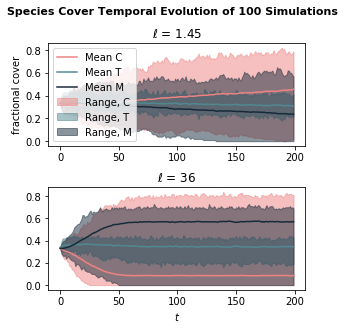

In [203]:
## Plot

fig, ax = plt.subplots(2,1,figsize=(4.6,4.6))


ax[0].fill_between(time, minC_145, maxC_145, alpha=.5, color='#EE8382', label='Range, C')
ax[0].fill_between(time, minT_145, maxT_145, alpha=.5, color='#508991', label='Range, T')
ax[0].fill_between(time, minM_145, maxM_145, alpha=.5, color='#172A3A', label='Range, M')

ax[0].plot(time, meanC_145, 'k-', color='#EE8382', label='Mean C')
ax[0].plot(time, meanT_145, 'k-', color='#508991', label='Mean T')
ax[0].plot(time, meanM_145, 'k-', color='#172A3A', label='Mean M')
ax[0].legend(loc='upper left')
ax[0].set_title("$\ell$ = 1.45")
ax[0].set_ylabel("fractional cover")

ax[1].fill_between(time, minC_36, maxC_36, alpha=.5, color='#EE8382')
ax[1].fill_between(time, minT_36, maxT_36 , alpha=.5, color='#508991')
ax[1].fill_between(time, minM_36, maxM_36, alpha=.5, color='#172A3A')

ax[1].plot(time, meanC_36, 'k-', color='#EE8382')
ax[1].plot(time, meanT_36, 'k-', color='#508991')
ax[1].plot(time, meanM_36, 'k-', color='#172A3A')

ax[1].set_title("$\ell$ = 36")
ax[0].set_ylabel("fractional cover")


plt.suptitle('Species Cover Temporal Evolution of 100 Simulations',fontsize =11, fontweight='bold')
plt.xlabel(r"$t$")


#plt.suptitle("Early Evolution, \n $t$ = 10",fontweight='bold',fontsize=12)
fig.subplots_adjust(hspace=.4, top=.87)
plt.savefig(path + name + extension, dpi=400, bbox_inches = "tight", facecolor=output_facecolor)

____
____
____
# Testing And Alternatives Below:
____
____
____

In [ ]:
name = 'threshold_timeseries'

sns.relplot(x="timestep", y="coral_percent", units='simulation', estimator=None, data=df, 
            row='grazing', hue='coral_success', col='neighborhood_threshold', kind="line", 
            height=1.5, aspect=2.7, alpha=.3)##.legend(loc='bottom')

plt.savefig(path+name+extension, dpi=400)

In [ ]:
#Pull fractional cover

df['C'] = round(df.coral_percent/100,2)
df['T'] = round(df.turf_percent/100,2)
df['M'] = round(df.macroalgae_percent/100,2)

dfplot = df.copy()

df_to_melt = dfplot[['C','timestep', 'time', 'simulation', 'M', 'T']]
df_melted = pd.melt(df_to_melt, id_vars=['timestep','time','simulation'], value_vars=['C', 'T','M'])
df_melted.head()

## Isolate Statistical Descriptors of Example Run

maxC = df[['C','time']].groupby('time').max()['C']
minC = df[['C','time']].groupby('time').min()['C']
meanC = df[['C','time']].groupby('time').mean()['C']

maxT = df[['T','time']].groupby('time').max()['T']
minT = df[['T','time']].groupby('time').min()['T']
meanT = df[['T','time']].groupby('time').mean()['T']

maxM = df[['M','time']].groupby('time').max()['M']
minM = df[['M','time']].groupby('time').min()['M']
meanM = df[['M','time']].groupby('time').mean()['M']

C = df[df['simulation']==simulation]['C']
T = df[df['simulation']==simulation]['T']
M = df[df['simulation']==simulation]['M']

time = df['time'].unique()

In [101]:
df_full = df.copy()
thresholds = [145,3600]

/Users/rosannaneuhausler/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/rosannaneuhausler/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/rosannaneuhausler/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

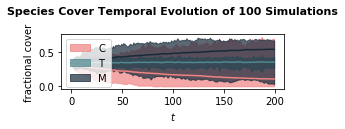

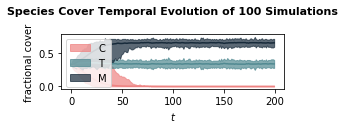

In [102]:
for threshold in thresholds:
    
    df = df_full[(df_full['neighborhood_threshold']==threshold)&
                 (df_full['grazing']==51)&
                 (df_full['time']<200)]

    #Pull fractional cover

    df['C'] = round(df.coral_percent/100,2)
    df['T'] = round(df.turf_percent/100,2)
    df['M'] = round(df.macroalgae_percent/100,2)

    dfplot = df.copy()

    df_to_melt = dfplot[['C','timestep', 'time', 'simulation', 'M', 'T']]
    df_melted = pd.melt(df_to_melt, id_vars=['timestep','time','simulation'], value_vars=['C', 'T','M'])
    df_melted.head()

    ## Isolate Statistical Descriptors of Example Run

    maxC = df[['C','time']].groupby('time').max()['C']
    minC = df[['C','time']].groupby('time').min()['C']
    meanC = df[['C','time']].groupby('time').mean()['C']

    maxT = df[['T','time']].groupby('time').max()['T']
    minT = df[['T','time']].groupby('time').min()['T']
    meanT = df[['T','time']].groupby('time').mean()['T']

    maxM = df[['M','time']].groupby('time').max()['M']
    minM = df[['M','time']].groupby('time').min()['M']
    meanM = df[['M','time']].groupby('time').mean()['M']

    C = df[df['simulation']==simulation]['C']
    T = df[df['simulation']==simulation]['T']
    M = df[df['simulation']==simulation]['M']

    time = df['time'].unique()


    ## Plot Min/Max/Example Timeseries

    name ='min_max_mean_timeseries_threshold_' + str(threshold)
    plt.figure(figsize=(4,1))

    plt.fill_between(time, minC, maxC, alpha=.7, color='#EE8382', label='C')
    plt.fill_between(time, minT, maxT , alpha=.7, color='#508991', label='T')
    plt.fill_between(time, minM, maxM, alpha=.7, color='#172A3A', label='M')

    plt.plot(time, meanC, 'k-', color='#EE8382')
    plt.plot(time, meanT, 'k-', color='#508991')
    plt.plot(time, meanM, 'k-', color='#172A3A')

    plt.title('Species Cover Temporal Evolution of 100 Simulations',fontsize =11, fontweight='bold',pad=20)
    plt.legend(loc='upper left')
    plt.ylabel("fractional cover")
    plt.xlabel(r"$t$")

    plt.savefig(path + name + extension, bbox_inches = "tight", facecolor=output_facecolor)

In [ ]:
for graze in grazing:
    
    df = df_full[(df_full['neighborhood_threshold']==3600)&
                 (df_full['grazing']==graze)&
                 (df_full['time']<200)]

    #Pull fractional cover

    df['C'] = round(df.coral_percent/100,2)
    df['T'] = round(df.turf_percent/100,2)
    df['M'] = round(df.macroalgae_percent/100,2)

    dfplot = df.copy()

    df_to_melt = dfplot[['C','timestep', 'time', 'simulation', 'M', 'T']]
    df_melted = pd.melt(df_to_melt, id_vars=['timestep','time','simulation'], value_vars=['C', 'T','M'])
    df_melted.head()

    ## Isolate Statistical Descriptors of Example Run

    maxC = df[['C','time']].groupby('time').max()['C']
    minC = df[['C','time']].groupby('time').min()['C']
    meanC = df[['C','time']].groupby('time').mean()['C']

    maxT = df[['T','time']].groupby('time').max()['T']
    minT = df[['T','time']].groupby('time').min()['T']
    meanT = df[['T','time']].groupby('time').mean()['T']

    maxM = df[['M','time']].groupby('time').max()['M']
    minM = df[['M','time']].groupby('time').min()['M']
    meanM = df[['M','time']].groupby('time').mean()['M']

    C = df[df['simulation']==simulation]['C']
    T = df[df['simulation']==simulation]['T']
    M = df[df['simulation']==simulation]['M']

    time = df['time'].unique()


    ## Plot Min/Max/Example Timeseries

    name ='min_max_mean_timeseries_grazing_' + str(graze)
    plt.figure(figsize=(4,1))

    plt.fill_between(time, minC, maxC, alpha=.7, color='#EE8382', label='C')
    plt.fill_between(time, minT, maxT , alpha=.7, color='#508991', label='T')
    plt.fill_between(time, minM, maxM, alpha=.7, color='#172A3A', label='M')

    plt.plot(time, meanC, 'k-', color='#EE8382')
    plt.plot(time, meanT, 'k-', color='#508991')
    plt.plot(time, meanM, 'k-', color='#172A3A')

    plt.title('Species Cover Temporal Evolution of 100 Simulations',fontsize =11, fontweight='bold',pad=20)
    plt.legend(loc='upper left')
    plt.ylabel("fractional cover")
    plt.xlabel(r"$t$")

    plt.savefig(path + name + extension, bbox_inches = "tight")

## 3C Visual Evolution

## Grazing = .51

In [ ]:
# Data Overview
grazing = 51
subset = runs[(runs['number_of_timesteps']==1100)&
              (runs['number_of_rows']==25)&
              (runs['grazing']==grazing)&
              (runs['grid_option']==0)&
              (runs['initial_coral_percent']==33)]
subset

In [ ]:
# Load Data

df = tl.load_runs(files, subset)
df = tl.split_neighbors(df)
df = tl.add_percent(df)
df = tl.label_crash_statistics(df, coral_success=70)

df['time'] = df['timestep']*.1
df['time'] = df['time'].astype('int')
df['C'] = round(df.coral_percent/100,2)
df['T'] = round(df.turf_percent/100,2)
df['M'] = round(df.macroalgae_percent/100,2)

In [ ]:
df_to_melt_145 = df[df['neighborhood_threshold']==145][['C','time','simulation', 'M', 'T']]
df_melted_145 = pd.melt(df_to_melt_145, id_vars=['time','simulation'], value_vars=['C', 'T','M'])

df_to_melt_500 = df[df['neighborhood_threshold']==500][['C','time','simulation', 'M', 'T']]
df_melted_500 = pd.melt(df_to_melt_500, id_vars=['time','simulation'], value_vars=['C', 'T','M'])

df_to_melt_1100 = df[df['neighborhood_threshold']==1100][['C','time','simulation', 'M', 'T']]
df_melted_1100 = pd.melt(df_to_melt_1100, id_vars=['time','simulation'], value_vars=['C', 'T','M'])

df_to_melt_3600 = df[df['neighborhood_threshold']==3600][['C','time','simulation', 'M', 'T']]
df_melted_3600 = pd.melt(df_to_melt_3600, id_vars=['time','simulation'], value_vars=['C', 'T','M'])

In [ ]:
df_145 = df[df['neighborhood_threshold']==145]
df_3600 = df[df['neighborhood_threshold']==3600]

In [ ]:
df_145['C'].min()

In [ ]:
maxC = df_145[['C','time']].groupby('time').max()['C']
minC = df_145[['C','time']].groupby('time').min()['C']
meanC = df_145[['C','time']].groupby('time').mean()['C']

maxT = df_145[['T','time']].groupby('time').max()['T']
minT = df_145[['T','time']].groupby('time').min()['T']
meanT = df_145[['T','time']].groupby('time').mean()['T']

maxM = df_145[['M','time']].groupby('time').max()['M']
minM = df_145[['M','time']].groupby('time').min()['M']
meanM = df_145[['M','time']].groupby('time').mean()['M']

C = df_145[df_145['simulation']==simulation]['C']
T = df_145[df_145['simulation']==simulation]['T']
M = df_145[df_145['simulation']==simulation]['M']

time = df['time'].unique()

In [ ]:
plt.figure(figsize=(12,2))



plt.fill_between(time, minC, maxC, alpha=.2, color='#EE8382')
plt.fill_between(time, minM, maxM, alpha=.2, color='#508991')
plt.fill_between(time, minT, maxT, alpha=.2, color='#172A3A')

plt.plot(time, C, 'k-', color='#dafa73')
plt.plot(time, T, 'k-', color='#73fafa')
plt.plot(time, M, 'k-', color='#fa73e3')

plt.show()

In [ ]:
df_145 = df[df['neighborhood_threshold']==145]
df_3600 = df[df['neighborhood_threshold']==3600]

plt.figure(figsize=(12,2))


plt.fill_between(time, df_145['C'].min(), maxC, alpha=.2, color='#dafa73')
plt.fill_between(time, minM, maxM, alpha=.2, color='#73fafa')
plt.fill_between(time, minT, maxT, alpha=.2, color='#fa73e3')

plt.plot(time, df_145['C'], 'k-', color='#dafa73')
plt.plot(time, df_145['T'], 'k-', color='#73fafa')
plt.plot(time, df_145['M'], 'k-', color='#fa73e3')

plt.show()

In [ ]:
name='boxplot_temporal_evolution_145_grazing_' + str(grazing)

#times = [0,40, 80, 120, 160, 200, 240, 280]

times = [0,10,20,30,40,50,60,70,80,90,100]

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_145[df_melted_145['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)
#plt.legend([],[], frameon=False)
plt.ylabel('fractional cover')
plt.xlabel('$t$')
plt.legend(loc='upper left')

plt.title('$\ell$ = 1.45,  $g$ = .' + str(grazing))
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

In [ ]:
name='boxplot_temporal_evolution_1100_grazing_' + str(grazing)

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
            data=df_melted_1100[df_melted_1100['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))


plt.setp(fig.get_xticklabels(), rotation=45)

plt.ylabel('fractional cover')
plt.xlabel('$t$')
plt.legend([],[], frameon=False)


plt.title('$\ell$ = 11.00,  $g$ = .' + str(grazing))
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

In [ ]:
name='boxplot_temporal_evolution_3600_grazing_' + str(grazing)

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_3600[df_melted_3600['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)

plt.ylabel('fractional cover')
plt.xlabel('$t$')

plt.legend([],[], frameon=False)


plt.title('$\ell$ = 36.00,  $g$ = .' + str(grazing))
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

In [ ]:
name = 'initial_profile'

time = 0
threshold = 1.45

data=df[df['neighborhood_threshold']==int(threshold*100)]    
image = prep_image(data, simulation, time)
reef = reef_from_image(image, threshold=threshold, number_of_rows=25, number_of_columns=25)
coral_count = np.count_nonzero(image==0)
neighbors = extract_neighbors(reef, int(0), coral_count)


fig, ax = plt.subplots(1,5, figsize=(6,2.45))

ax[0].imshow(image, cmap=cmap, norm=norm)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].set_frame_on(False)

ax[1].text(0.35, 0.5,
           '$C$: ' + str(round(coral_count/(number_of_rows*number_of_columns), 2)),
           size=12, ha='center', va='center')
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_frame_on(False)

ax[2].text(0.35, 0.5,
           '$C_C$: ' + str(round(neighbors[0],3)),
           size=12, ha='center', va='center')
ax[2].axes.xaxis.set_visible(False)
ax[2].axes.yaxis.set_visible(False)
ax[2].set_frame_on(False)


ax[3].text(0.35, 0.5,
           '$T_C$: ' + str(round(neighbors[1],3)),
           size=12, ha='center', va='center')
ax[3].axes.xaxis.set_visible(False)
ax[3].axes.yaxis.set_visible(False)
ax[3].set_frame_on(False)

ax[4].text(0.35, 0.5,
           '$M_C$: ' + str(round(neighbors[2],3)),
           size=12, ha='center', va='center')
ax[4].axes.xaxis.set_visible(False)
ax[4].axes.yaxis.set_visible(False)
ax[4].set_frame_on(False)

plt.suptitle("Profiles, $t$ = 10")
fig.subplots_adjust(wspace=0.2, top=1.3)
plt.savefig(path + name + extension, dpi=400, bbox_inches = "tight")

In [ ]:
name = 'early_spatial_evolution_images_145_grazing_' + str(grazing)

time = 10
threshold = 1.45


data=df[df['neighborhood_threshold']==int(threshold*100)]    
image = prep_image(data, simulation, time)
reef = reef_from_image(image, threshold=threshold, number_of_rows=25, number_of_columns=25)
coral_count = np.count_nonzero(image==0)
neighbors = extract_neighbors(reef, int(0), coral_count)


fig, ax = plt.subplots(1,2, figsize=(3.5,2.45), gridspec_kw={'width_ratios': [2, 1]})

ax[0].imshow(image, cmap=cmap, norm=norm)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].set_frame_on(False)

ax[1].text(0.35, 0.5,
           '$C$: ' + str(round(coral_count/(number_of_rows*number_of_columns), 2)) + 
           '\n \n' + 'neighbors: ' + 
           '\n $C_C$: ' + str(round(neighbors[0],3)) + 
           '\n $T_C$: ' + str(round(neighbors[1],3)) +
           '\n $M_C$: ' + str(round(neighbors[2],3)),
           size=12, ha='center', va='center')
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_frame_on(False)

plt.suptitle('$t$ = ' + str(int(time)) + 
                            ',  $\ell$ = ' + str(threshold) + 
                            ', $g$ = .' + str(grazing))
fig.subplots_adjust(wspace=0.2, top=.9)
plt.savefig(path + name + extension, dpi=400, bbox_inches = "tight")

In [ ]:
name = 'early_spatial_evolution_images_36_grazing_' + str(grazing)

time = 10
threshold = 36

data=df[df['neighborhood_threshold']==int(threshold*100)]    
image = prep_image(data, simulation, time)
reef = reef_from_image(image, threshold=threshold, number_of_rows=25, number_of_columns=25)
coral_count = np.count_nonzero(image==0)
neighbors = extract_neighbors(reef, int(0), coral_count)


fig, ax = plt.subplots(1,2, figsize=(3.5,2.45), gridspec_kw={'width_ratios': [2, 1]})

ax[0].imshow(image, cmap=cmap, norm=norm)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].set_frame_on(False)

ax[1].text(0.35, 0.5,
           '$C$: ' + str(round(coral_count/(number_of_rows*number_of_columns), 2)) + 
           '\n \n' + 'neighbors: ' + 
           '\n $C_C$: ' + str(round(neighbors[0],3)) + 
           '\n $T_C$: ' + str(round(neighbors[1],3)) +
           '\n $M_C$: ' + str(round(neighbors[2],3)),
           size=12, ha='center', va='center')
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].set_frame_on(False)

plt.suptitle('$t$ = ' + str(int(time)) + 
                            ',  $\ell$ = ' + str(threshold) + 
                            ', $g$ = .' + str(grazing))
fig.subplots_adjust(wspace=0.2, top=.9)
plt.savefig(path + name + extension, dpi=400, bbox_inches = "tight")

In [ ]:
threshold = 1.45
name = 'early_spatial_evolution_images_145_grazing_' + str(grazing)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, times=times, grazing=grazing)

In [ ]:
threshold = 36
name = 'early_spatial_evolution_images_3600_grazing_' + str(grazing)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, grazing=grazing)

## Grazing = .54

In [ ]:
grazing = 54
subset = runs[(runs['number_of_timesteps']==1100)&
              (runs['number_of_rows']==25)&
              (runs['grazing']==grazing)&
              (runs['grid_option']==0)&
              (runs['initial_coral_percent']==33)]
subset

In [ ]:
df = tl.load_runs(files, subset)
df = tl.split_neighbors(df)
df = tl.add_percent(df)
df['time'] = df['timestep']*.1
df['time'] = df['time'].astype('int')
df['C'] = round(df.coral_percent/100,2)
df['T'] = round(df.turf_percent/100,2)
df['M'] = round(df.macroalgae_percent/100,2)

In [ ]:
variable='coral_percent'
sns.relplot(x="time", y=variable, 
            units="simulation", estimator=None, 
            data=df, kind="line",
            row='neighborhood_threshold',
            height=1, alpha=.8, aspect=3)

In [ ]:
df_to_melt_145 = df[df['neighborhood_threshold']==145][['C','time','simulation', 'M', 'T']]
df_melted_145 = pd.melt(df_to_melt_145, id_vars=['time','simulation'], value_vars=['C', 'T','M'])

df_to_melt_500 = df[df['neighborhood_threshold']==500][['C','time','simulation', 'M', 'T']]
df_melted_500 = pd.melt(df_to_melt_500, id_vars=['time','simulation'], value_vars=['C', 'T','M'])

df_to_melt_1100 = df[df['neighborhood_threshold']==1100][['C','time','simulation', 'M', 'T']]
df_melted_1100 = pd.melt(df_to_melt_1100, id_vars=['time','simulation'], value_vars=['C', 'T','M'])

df_to_melt_3600 = df[df['neighborhood_threshold']==3600][['C','time','simulation', 'M', 'T']]
df_melted_3600 = pd.melt(df_to_melt_3600, id_vars=['time','simulation'], value_vars=['C', 'T','M'])

In [ ]:
name='boxplot_temporal_evolution_145_grazing_' + str(grazing)

#times = [0,40, 80, 120, 160, 200, 240, 280]

times = [0,10,20,30,40,50,60,70,80,90,100]

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_145[df_melted_145['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)
#plt.legend([],[], frameon=False)
plt.ylabel('fractional cover')
plt.xlabel('$t$')
plt.legend(loc='upper left')

plt.title('$\ell$ = 1.45,  $g$ = .' + str(grazing))
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

In [ ]:
name='boxplot_temporal_evolution_1100_grazing_' + str(grazing)

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
            data=df_melted_1100[df_melted_1100['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))


plt.setp(fig.get_xticklabels(), rotation=45)

plt.ylabel('fractional cover')
plt.xlabel('$t$')
plt.legend([],[], frameon=False)


plt.title('$\ell$ = 11.00,  $g$ = .' + str(grazing))
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

In [ ]:
name='boxplot_temporal_evolution_3600_grazing_' + str(grazing)

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_3600[df_melted_3600['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)

plt.ylabel('fractional cover')
plt.xlabel('$t$')

plt.legend([],[], frameon=False)


plt.title('$\ell$ = 36.00,  $g$ = .' + str(grazing))
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

In [ ]:
threshold = 1.45
name = 'early_spatial_evolution_images_145_grazing_' + str(grazing)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, times=times, grazing=grazing)

In [ ]:
threshold = 36
name = 'early_spatial_evolution_images_3600_grazing_' + str(grazing)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, grazing=grazing)

In [ ]:
grazing = 54
subset = runs[(runs['number_of_timesteps']==3000)&
              (runs['number_of_rows']==25)&
              (runs['grazing']==grazing)&
              (runs['grid_option']==0)&
              (runs['initial_coral_percent']==33)]
subset

In [ ]:
df = tl.load_runs(files, subset)
df = tl.split_neighbors(df)
df = tl.add_percent(df)
df['time'] = df['timestep']*.1
df['time'] = df['time'].astype('int')

In [ ]:
variable='coral_percent'
sns.relplot(x="time", y=variable, 
            units="simulation", estimator=None, 
            data=df, kind="line",
            row='neighborhood_threshold',
            height=1, alpha=.8, aspect=3)

In [ ]:
df_to_melt_145 = df[df['neighborhood_threshold']==145][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_145 = pd.melt(df_to_melt_145, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

df_to_melt_500 = df[df['neighborhood_threshold']==500][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_500 = pd.melt(df_to_melt_500, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

df_to_melt_1100 = df[df['neighborhood_threshold']==1100][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_1100 = pd.melt(df_to_melt_1100, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

df_to_melt_3600 = df[df['neighborhood_threshold']==3600][['coral_percent','time','simulation', 'macroalgae_percent', 'turf_percent']]
df_melted_3600 = pd.melt(df_to_melt_3600, id_vars=['time','simulation'], value_vars=['coral_percent', 'turf_percent','macroalgae_percent'])

In [ ]:
name='boxplot_temporal_evolution_145_grazing_' + str(grazing)

times = [0,40, 80, 120, 160, 200, 240, 280]

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_145[df_melted_145['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)
plt.legend([],[], frameon=False)
plt.title('Neighborhood Threshold = 1.45')

plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

In [ ]:
name='boxplot_temporal_evolution_1100_grazing_' + str(grazing)

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
            data=df_melted_1100[df_melted_1100['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))


plt.setp(fig.get_xticklabels(), rotation=45)
plt.legend([],[], frameon=False)
plt.title('Neighborhood Threshold = 11.00')

plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

In [ ]:
name='boxplot_temporal_evolution_3600_grazing_' + str(grazing)

plt.figure(figsize=(3,3))
fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_3600[df_melted_3600['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)
plt.title('Neighborhood Threshold = 36.00')
plt.legend([],[], frameon=False)
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

In [ ]:
threshold = 1.45
name = 'early_spatial_evolution_images_145_grazing_' + str(grazing)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, times=times)

In [ ]:
threshold = 36
name = 'early_spatial_evolution_images_3600_grazing_' + str(grazing)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, times=times)

______

### Previous Image Plot

____

In [ ]:
name='boxplot_temporal_evolution_500_grazing_' + str(grazing)

plt.figure(figsize=(3,3))

fig=sns.boxplot(x="time", y="value", hue="variable",
                data=df_melted_500[df_melted_500['time'].isin(times)], 
                palette=species_palette,
                linewidth=.5,
                flierprops=dict(markersize=2))

plt.setp(fig.get_xticklabels(), rotation=45)
plt.legend([],[], frameon=False)
plt.title('Neighborhood Threshold = 5.00')
#ax._legend.remove()
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

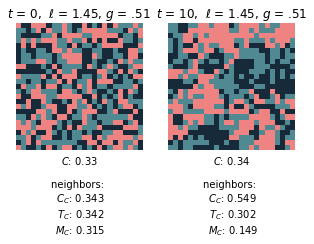

In [46]:
def annotated_image_plots(threshold=1.45, name='example', 
                          simulation=1, times=[0,10], grazing=51):
    
    data=df[df['neighborhood_threshold']==int(threshold*100)]    
    fig, ax = plt.subplots(1, len(times), figsize=(5,5)) 

    for index in range(0, len(times)):

        image = prep_image(data,simulation,times[index])
        reef = reef_from_image(image, threshold=threshold, number_of_rows=25, number_of_columns=25)
        coral_count = np.count_nonzero(image==0)
        neighbors = extract_neighbors(reef, int(0), coral_count)
        ax[index].imshow(image, cmap=cmap, norm=norm)
        ax[index].set_xticks([])
        ax[index].set_title('$t$ = ' + str(int(times[index])) + 
                            ',  $\ell$ = ' + str(threshold) + 
                            ', $g$ = .' + str(grazing))
        ax[index].set_xlabel('$C$: ' 
                             + str(round(coral_count/(number_of_rows*number_of_columns), 2))
                             + '\n \n' + 'neighbors: ' + 
                             '\n $C_C$: ' +str(round(neighbors[0],3))+ 
                             '\n $T_C$: ' + str(round(neighbors[1],3)) +
                             '\n $M_C$: ' + str(round(neighbors[2],3)))
        ax[index].axes.yaxis.set_visible(False)        
        ax[index].set_frame_on(False)
    #fig.suptitle(title)
    fig.subplots_adjust(wspace=0.2, top=.75)
    plt.savefig(path + name + extension, dpi=400)
    
    


threshold = 1.45
name = 'early_spatial_evolution_images_145_grazing_' + str(51)
simulation = 1
times = [0, 10]

annotated_image_plots(threshold=threshold, name=name, 
                      simulation=simulation, times=times)

In [ ]:

def annotated_image_plots(threshold=1.45, name='example', 
                          simulation=1, time=10, grazing=51):
    
    data=df[df['neighborhood_threshold']==int(threshold*100)]    
    image = prep_image(data, simulation, time)
    reef = reef_from_image(image, threshold=threshold, number_of_rows=25, number_of_columns=25)
    coral_count = np.count_nonzero(image==0)
    neighbors = extract_neighbors(reef, int(0), coral_count)


    fig, ax = plt.subplots(1,2, figsize=(3.5,2.45), gridspec_kw={'width_ratios': [2, 1]})

    ax[0].imshow(image, cmap=cmap, norm=norm)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
    ax[0].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
    ax[0].set_frame_on(False)
    ax[0].grid(color='black', linestyle='-', linewidth=.1, which='minor')
    ax[0].tick_params(which='minor',top=[], left=[],right=[], bottom=[])
    ax[0].set_frame_on(True)
    ax[0].set_title("$\ell$ = " + str(threshold))

    ax[1].text(0.35, 0.5,
               '$C$: ' + str(round(coral_count/(number_of_rows*number_of_columns), 2)) + 
               '\n \n' + 'neighbors: ' + 
               '\n $C_C$: ' + str(round(neighbors[0],3)) + 
               '\n $T_C$: ' + str(round(neighbors[1],3)) +
               '\n $M_C$: ' + str(round(neighbors[2],3)),
               size=12, ha='center', va='center')
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    ax[1].set_frame_on(False)

    #plt.suptitle("Time ($t$) = 10 \n  ,  $\ell$ = " + str(threshold),fontweight='bold',fontsize=12.5)
    fig.subplots_adjust(wspace=0.2, top=.79)
    plt.savefig(path + name + extension, dpi=400, bbox_inches = "tight")    
    
    
    
    
    